<a href="https://colab.research.google.com/github/polortiz4/Smart-Cameras/blob/master/HW4colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 590 Smart Cameras 
## Fall 2019
## Homework 4
## Learning to Focus 

In [126]:
from time import gmtime, strftime, sleep
from scipy.io import loadmat
from scipy.signal import fftconvolve
import numpy as np
import skimage.io as imio
import skimage.color as color
import random
import os
import cv2
import time
import sys
import urllib.request
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = (16.0, 8.0) 
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.cmap'] = 'gray'
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D
from keras.utils import Sequence
from keras.callbacks import TensorBoard as tensorboard
from keras import backend as K

In [55]:
spam_loader = import.util.find_spec('google.colab')
if spam_loader is not None:
    from google.colab import drive
    from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

    drive.mount('/content/gdrive')
    os.chdir('/content/gdrive/My Drive/Smart-Cameras/HW4')

The file defocus.mat provides a focus model for the the tegra camera on line at nvidia@10.236.176.37. The structure of the model is discussed in the paper "Intelligent Autofocus" distributed in class. The model is a 210*4 matrix. The first column is the focus position Z_0, the second column is the defocus position Z_i, the third column is the defocus radius r for disk filter, and the fourth column is the scaling factor \alpha. (Same notations as in the paper, Section III IMAGE DEFOCUS MODEL)

The focus on this camera is adjusted using the python scripts moveFocusMotor.py and resetFocusMotor.py as in previous homework. You can see the current focus position by running the command python2 

moveFocusMotor.py sid 0


where sid is the sensor number. sid can be 1 or 2, corresponding as before to sensor 0 or 1 for the nvgstcapture command. 

In [2]:
deFocusModel = loadmat('defocus.mat')["defocus_model"]

As shown in the plot below, the focus position scales between 1100 and 2000. The defocus position can then scale between 1100 and 2000, as shown in the orange curve, for each defocus value, there is a corresponding defocus blur diameter, as shown in the green curve at the bottom.

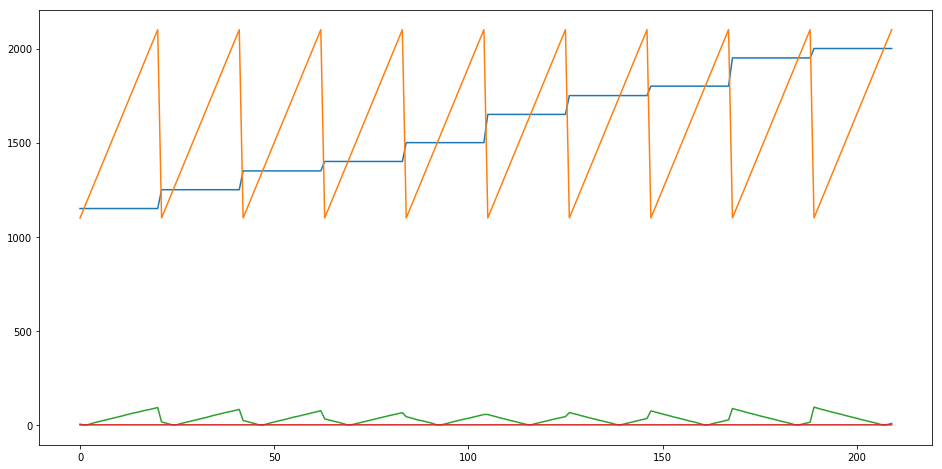

In [127]:
plt.plot(deFocusModel)

In this homework you should use the high resolution images in the libraries at 

CLIC dataset
http://www.compression.cc/challenge/

DIV2K
https://data.vision.ee.ethz.ch/cvl/DIV2K/

To generate training and test image data sets corresponding to {blurredImage, AbsoluteRangeToFocusPosition} pairs. Use the training data (with patch size 256) to train a network to estimate absolute range to focus position from an input image. Test your train network with the task of focusing the camera on online at nvidia@10.236.176.37  

The camera contains objects at various fields of view within its range, test separately on different regions of interest to evaluate your autofocus system. 

# Generate Training and Test data

In [80]:
def update_progress(progress, barLength = 100):
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rPercent: [{0}] {1:0.3}% {2}".format( "#"*block + "-"*(barLength-block), progress*100, status)
    sys.stdout.write(text)
    sys.stdout.flush()

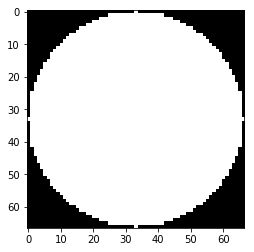

In [4]:
def kernel(r, pitch = 1):
    if r == 0:
        r = pitch
    r_length = int(r / pitch)
    x = np.arange(-r_length, r_length + 1)
    y = np.arange(-r_length, r_length + 1)
    xx, yy = np.meshgrid(x, y)
    kernel = np.zeros_like(xx)
    kernel = (xx**2 + yy**2 <= r_length**2)
    kernel = kernel / sum(sum(kernel))
    
    return kernel
kernel_example = kernel(33)
plt.imshow(kernel_example)

In [5]:
def forward_model(image, r, alpha = 1):
    if r != 0:
        image = fftconvolve(image, kernel(r), mode = 'valid')
    blur_scale = cv2.resize(image, None, fx = alpha, fy = alpha)

    
    return blur_scale[:512, :512]

In [6]:
def divide_image(image, block_size = 512, alpha = 0.949, r = 95):
    preblur_size = int(block_size / min(deFocusModel[:, 3]) + 2 * max(deFocusModel[:, 2]))
    blocks = np.zeros([1, preblur_size, preblur_size])
    
    row_length = image.shape[0] - np.mod(image.shape[0], block_size) + preblur_size - block_size
    col_length = image.shape[1] - np.mod(image.shape[1], block_size) + preblur_size - block_size

    if np.mod(image.shape[0], block_size) < preblur_size - block_size:
        row_length -= block_size
    if np.mod(image.shape[1], block_size) < preblur_size - block_size:
        col_length -= block_size
    row_length = int(np.floor(row_length / block_size))
    col_length = int(np.floor(col_length / block_size))
    for row in range(row_length):
        for col in range (col_length):
            block = image[block_size*row : block_size*row + preblur_size, block_size*col : block_size*col + preblur_size]
            blocks = np.append(blocks, block[np.newaxis, :, :], axis = 0)
            
    if image.shape[0] < preblur_size or image.shape[1] < preblur_size:
        block = cv2.resize(image, (preblur_size, preblur_size))
        blocks = np.append(blocks, block[np.newaxis, :, :], axis = 0)
    
    return blocks[1:, :, :]

In [8]:
def pre_process(filename, folder, block_size = 512, idx = 0):
    image = imio.imread(folder + '/' + filename)
    image = color.rgb2gray(image)
    blocks = divide_image(image)
    dir_labels = {}
    np_labels = np.array([])
    for i, block in enumerate(blocks):
        z0 = random.choice(np.unique(deFocusModel[:, 0]))
        z1 = random.choice(np.unique(deFocusModel[:, 1]))
        r = deFocusModel[np.where(np.multiply(deFocusModel[:, 1] == z1, deFocusModel[:, 0] == z0)), 2]
        alpha = deFocusModel[np.where(np.multiply(deFocusModel[:, 1] == z1, deFocusModel[:, 0] == z0)), 3]        
        block = block[:int(np.ceil(block_size/alpha + 2*r)), :int(np.ceil(block_size/alpha + 2*r))]
        blur_block = forward_model(block, r, alpha)
#         if blur_block.shape == (block_size, block_size):
        cv2.imwrite(folder + '_data/' + folder + '_image_' + str(idx) + '.png', 256 * blur_block)
        dir_labels[folder + '_image_' + str(idx) + '.png'] = abs(z1 - z0)
        np_labels = np.append(np_labels, abs(z1 - z0))
        idx += 1
        
    return dir_labels, np_labels, idx


In [9]:
%%time
overwrite = False
if overwrite:
    folder = 'train'
    if not os.path.exists(folder + str('_data')):
        os.makedirs(folder + str('_data'))
    if not os.path.exists(folder + str('_labels')):
        os.makedirs(folder + str('_labels'))
    leng = len(os.listdir(folder))
    dir_labels = {}
    idx = 0
    np_labels = []
    for i, filename in  enumerate(os.listdir(folder)):
        if not filename.startswith('.'):
            dir_label, np_label, idx = pre_process(filename = filename, folder = folder, idx = idx)
            dir_labels.update(dir_label)
            np_labels = np.append(np_labels, np_label)
        update_progress((i+1)/leng)
    np.save(folder + '_labels/' + folder + '_labels', np_labels)


    folder = 'valid'
    if not os.path.exists(folder + str('_data')):
        os.makedirs(folder + str('_data'))
    if not os.path.exists(folder + str('_labels')):
        os.makedirs(folder + str('_labels'))
    leng = len(os.listdir(folder))
    dir_labels = {}
    idx = 0
    np_labels = []
    for i, filename in  enumerate(os.listdir(folder)):
        if not filename.startswith('.'):
            dir_label, np_label, idx = pre_process(filename = filename, folder = folder, idx = idx)
            dir_labels.update(dir_label)
            np_labels = np.append(np_labels, np_label)
        update_progress((i+1)/leng)
    np.save(folder + '_labels/' + folder + '_labels', np_labels)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11.2 µs


In [11]:
folder = 'train_data'
train_names = []
idx = 0
for i, filename in  enumerate(os.listdir(folder)):
    if not filename.startswith('.'):
        train_names.append('train_data/train_image_' + str(idx) + '.png')
        idx += 1

idx = 0
folder = 'valid_data'
if not os.path.exists(folder):
    os.makedirs(newpath)
valid_names = []
for i, filename in  enumerate(os.listdir(folder)):
    if not filename.startswith('.'):
        valid_names.append('valid_data/valid_image_' + str(idx) + '.png')
        idx += 1


In [134]:
class My_Generator(Sequence):
    
    def __init__(self, image_filenames, labels, batch_size):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx + 1) * self.batch_size]

        
        return [np.array([imio.imread(file_name) for file_name in batch_x])[:, :, :, np.newaxis], batch_y]
    

In [152]:
batch_size = 32
my_train_batch_generator = My_Generator(train_names, np.load('train_labels/train_labels.npy'), batch_size)
my_valid_batch_generator = My_Generator(valid_names, np.load('valid_labels/valid_labels.npy'), batch_size)

In [153]:
def base_model():
  
  model = Sequential()
  model.add(Conv2D(4, (8, 8), strides = 8, padding = 'same', activation = 'relu', input_shape = (512, 512, 1)))
  model.add(Conv2D(8, (4, 4), strides = 4, padding = 'same', activation = 'relu'))
  model.add(Conv2D(8, (4, 4), strides = 4, padding = 'same', activation = 'relu'))
  model.add(Flatten())
  model.add(Dense(1024, activation = 'relu'))
  model.add(Dense(512, activation = 'relu'))
  model.add(Dense(10, activation = 'relu'))
  model.add(Dense(1))
  
  model.compile(loss = 'mean_squared_error', optimizer = 'adam')
  return model
K.clear_session()
cnn_n = base_model()
cnn_n.summary()
  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 4)         260       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 8)         520       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 8)           1032      
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              132096    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
__________

In [156]:
tbc = tensorboard(log_dir = 'logs/run_a', histogram_freq = 0, write_graph = True, write_images = True)
# Remember to run tensorboard on 127.0.0.1:6006, not whatever the terminal is saying

In [ ]:
epochs = 2
cnn = cnn_n.fit_generator(generator = my_train_batch_generator,
                           steps_per_epoch = len(train_names) // batch_size,
                           epochs = epochs,
                           validation_data = my_valid_batch_generator,
                           validation_steps = len(valid_names) // batch_size,
                           use_multiprocessing = True,
                           workers = 4,
                           callbacks = [tbc],
                           max_queue_size = 32)

Epoch 1/2
234/234 [==============================] - 70s 301ms/step - loss: 49169.1751 - val_loss: 37867.5791
Epoch 2/2
175/234 [=====================>........] - ETA: 18s - loss: 41439.7163

In [ ]:
# Save the weights and the trained model 
cnn_n.save_weights('trained_weights.h5')
cnn_n.save('trained_model.h5')

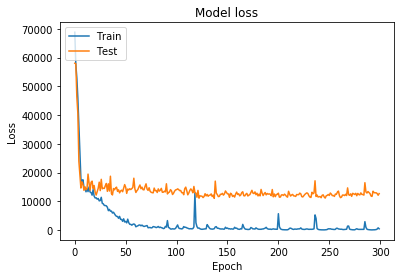

In [39]:
# Plot training & validation loss values
plt.plot(cnn.history['loss'])
plt.plot(cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

In [53]:
im_num = 120
print('Prediction: ' + str(cnn_n.predict(imio.imread('valid_data/valid_image_' + str(im_num) + '.png')[np.newaxis, :, :, np.newaxis])))
print('Ground Truth: ' + str(np.load('valid_labels/valid_labels.npy')[im_num]))

Prediction: [[567.80035]]
Ground Truth: 650.0
